In [17]:
# from glob import glob
# from PIL import Image
# import torchvision.transforms as T
# import torch
# from tqdm import tqdm

# image_paths = glob("/home/hiwe/project/deeplearning/project/handwriting/data/train/*.jpg")
# transform = T.ToTensor()

# mean = 0.
# std = 0.
# nb_samples = 0

# for path in tqdm(image_paths):
#     img = Image.open(path).convert("RGB")
#     tensor = transform(img)
#     nb_samples += 1
#     mean += tensor.mean(dim=(1, 2))
#     std += tensor.std(dim=(1, 2))

# mean /= nb_samples
# std /= nb_samples

# print(f"Mean: {mean}, Std: {std}")

In [18]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os
import torch

class OCRDataset(Dataset):
    def __init__(self, img_dir, label_csv, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.samples = pd.read_csv(label_csv)
        self.samples.columns = ['FILENAME', 'IDENTITY']
        
        self.samples = self.samples.dropna(subset=['IDENTITY'])
        self.samples['IDENTITY'] = self.samples['IDENTITY'].astype(str)
        all_text = ''.join(self.samples['IDENTITY'].tolist())
        unique_chars = sorted(set(all_text))
        
        self.blank_token = '<blank>'
        self.char2idx = {self.blank_token: 0}
        for idx, char in enumerate(unique_chars, start=1):
            self.char2idx[char] = idx

        self.idx2char = {v: k for k, v in self.char2idx.items()}
        self.blank_idx = self.char2idx[self.blank_token]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples.iloc[idx]
        img_path = os.path.join(self.img_dir, row['FILENAME'])
        label_text = row['IDENTITY']

        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)

        label_encoded = [self.char2idx[c] for c in label_text]
        label_tensor = torch.tensor(label_encoded, dtype=torch.long)
        label_length = len(label_encoded)
        
        return image, label_tensor, label_length

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader 
from torchvision.transforms import transforms
from model import BasicModel

# === Data transforms ===
train_transform = transforms.Compose([
    transforms.Resize((32, 256)),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

val_transform = transforms.Compose([
    transforms.Resize((32, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

# === Datasets ===
train_dataset = OCRDataset(
    img_dir='data/train',
    label_csv='train_labels.csv',
    transform=train_transform
)
val_dataset = OCRDataset(
    img_dir='data/validation',
    label_csv='val_labels.csv',
    transform=val_transform
)
test_dataset = OCRDataset(
    img_dir='data/test',
    label_csv='test_labels.csv',
    transform=val_transform
)

# === char2idx & blank ===
char2idx = train_dataset.char2idx
idx2char = {v: k for k, v in char2idx.items()}
blank_idx = char2idx['<blank>']

# === Decoder ===
def greedy_decoder(output, blank=0):
    output = output.permute(1, 0, 2)  # (T, N, C) → (N, T, C)
    decoded = []
    for probs in output:
        pred = torch.argmax(probs, dim=1)
        prev = -1
        new_seq = []
        for p in pred:
            p = p.item()
            if p != prev and p != blank:
                new_seq.append(p)
            prev = p
        decoded.append(new_seq)
    return decoded

# === Accuracy ===
def compute_accuracy(preds, targets, target_lengths):
    acc = 0
    total = len(target_lengths)
    split_targets = torch.split(targets, target_lengths.tolist())
    for pred, target in zip(preds, split_targets):
        if pred == target.tolist():
            acc += 1
    return acc / total

# === Collate function ===
def ocr_collate_fn(batch):
    images, labels, lengths = zip(*batch)
    images = torch.stack(images, 0)
    labels = torch.cat(labels)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return images, labels, lengths

# === DataLoader ===
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=ocr_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=ocr_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=ocr_collate_fn)

# === Model ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BasicModel(num_classes=len(char2idx)).to(device)
criterion = nn.CTCLoss(blank=blank_idx, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# === Training ===
num_epochs = 200
train_accuracy = []
train_losses = []
val_accuracy = []
val_losses = []
best = 0.0 
print("Start Training")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct, total = 0, 0

    for x, y, target_lengths in train_loader:
        x, y, target_lengths = x.to(device), y.to(device), target_lengths.to(device)
        optimizer.zero_grad()
        outputs = model(x)  # (T, N, C)

        input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(device)
        loss = criterion(outputs, y, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        decoded_preds = greedy_decoder(outputs.detach().cpu(), blank=blank_idx)
        split_targets = torch.split(y.cpu(), target_lengths.cpu().tolist())

        for pred, target in zip(decoded_preds, split_targets):
            if pred == target.tolist():
                correct += 1
            total += 1

    acc_train = 100.0 * correct / total
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy.append(acc_train)

    # === Print sample decode ===
    print(f"\n[Epoch {epoch}]")
    for i in range(min(3, len(decoded_preds))):
        pred_str = ''.join([idx2char[c] for c in decoded_preds[i]])
        true_str = ''.join([idx2char[c.item()] for c in split_targets[i]])
        print(f"Pred: {pred_str} | True: {true_str}")

    # === Validation ===
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for x, y, target_lengths in val_loader:
            x, y, target_lengths = x.to(device), y.to(device), target_lengths.to(device)
            outputs = model(x)
            input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(device)
            loss = criterion(outputs, y, input_lengths, target_lengths)
            val_loss += loss.item()

            decoded_preds = greedy_decoder(outputs.cpu(), blank=blank_idx)
            split_targets = torch.split(y.cpu(), target_lengths.cpu().tolist())

            for pred, target in zip(decoded_preds, split_targets):
                if pred == target.tolist():
                    correct += 1
                total += 1

    val_acc = 100.0 * correct / total
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy.append(val_acc)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {acc_train:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best:
        best = val_acc 
        torch.save(model.state_dict(), 'model_best.pth')
        print(f'Saving the model with {val_acc:.2f}')
        

torch.save(model.state_dict(), 'model_last.pth')
print(f'Saving the last model with {val_acc:.2f}')
# === Test ===
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels, lengths in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)

        logits = model(images)
        decoded_preds = greedy_decoder(logits.cpu(), blank=blank_idx)

        acc = compute_accuracy(decoded_preds, labels.cpu(), lengths.cpu())
        correct += acc * len(lengths)
        total += len(lengths)

test_accuracy = correct / total
print(f"\nFinal Test Accuracy: {test_accuracy:.3f}")

Start Training

[Epoch 0]
Pred:  | True: YSEE
Pred:  | True: TIAGO
Pred:  | True: EVAN
Train Loss: 3.8387, Train Acc: 0.00%, Val Loss: 3.1683, Val Acc: 0.00%

[Epoch 1]
Pred:  | True: JACINTO
Pred:  | True: WADSWORRE
Pred:  | True: OVIZE
Train Loss: 3.1546, Train Acc: 0.00%, Val Loss: 3.1417, Val Acc: 0.00%

[Epoch 2]
Pred:  | True: DADDE
Pred:  | True: ERWAN
Pred:  | True: MILENA
Train Loss: 3.1333, Train Acc: 0.00%, Val Loss: 3.1167, Val Acc: 0.00%

[Epoch 3]
Pred:  | True: CHOQUET
Pred:  | True: PINON
Pred:  | True: OUDOTDEDAINVILLE
Train Loss: 3.1178, Train Acc: 0.00%, Val Loss: 3.0965, Val Acc: 0.00%

[Epoch 4]
Pred:  | True: BRICEAU
Pred:  | True: GAELLE
Pred:  | True: FABIEN
Train Loss: 3.1034, Train Acc: 0.00%, Val Loss: 3.0960, Val Acc: 0.00%

[Epoch 5]
Pred: M | True: TANAIS
Pred: M | True: GENTEUIL
Pred: L | True: ACELYA
Train Loss: 3.0868, Train Acc: 0.00%, Val Loss: 3.0695, Val Acc: 0.00%

[Epoch 6]
Pred: L | True: QUENTIN
Pred: BE | True: MARIAH
Pred: A | True: ROY
Train 

In [22]:
def decode_prediction(output, idx2char, blank_idx=0):
    output = output.permute(1, 0, 2)
    pred_labels = torch.argmax(output, dim=2)

    pred_texts = []
    for seq in pred_labels:
        text = []
        prev = None
        for idx in seq:
            idx = idx.item()
            if idx != blank_idx and idx != prev:
                text.append(idx2char.get(idx, ''))
            prev = idx
        pred_texts.append(''.join(text))
    return pred_texts

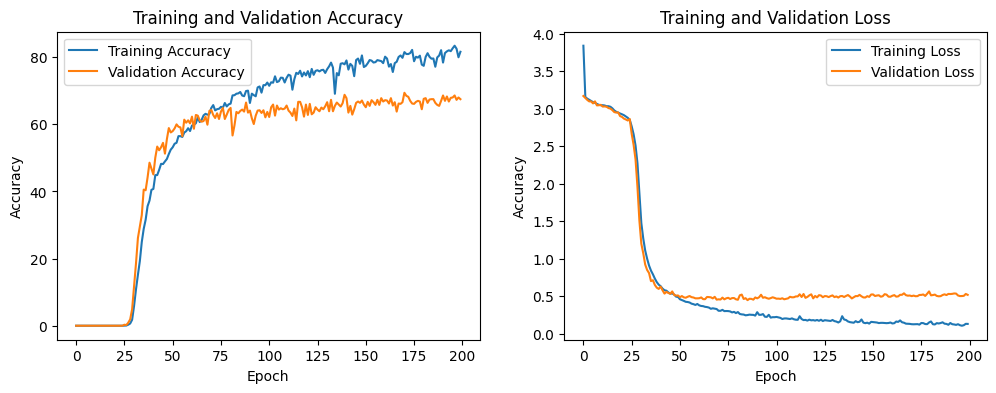

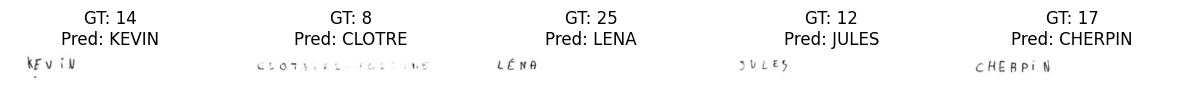

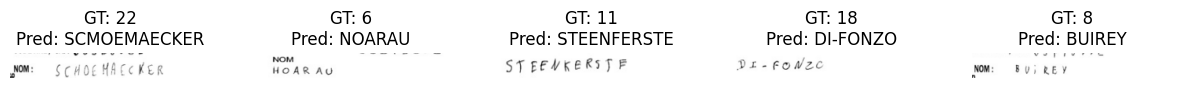

In [23]:
import matplotlib.pyplot as plt 


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Loss')

model.eval()
with torch.no_grad():
    for i, (images, labels, _) in enumerate(test_loader):
        if i >= 2:
            break

        images = images.to(device)
        outputs = model(images)

        pred_texts = decode_prediction(outputs, idx2char, blank_idx=0)

        gt_texts = [label for label in labels] 

        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        for j in range(min(5, len(images))):
            ax = axes[j]
            img = images[j].cpu().numpy().squeeze()
            ax.imshow(img, cmap='gray')
            ax.set_title(f"GT: {gt_texts[j]}\nPred: {pred_texts[j]}")
            ax.axis('off')
        plt.show()
